# SMDM 2 Project

In [24]:
import warnings ; warnings.warn = lambda *args,**kwargs: None
import numpy as np
import scipy.stats as spst
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import duckdb as duc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import chi2_contingency

We are going to use duckdb as our database engine. You can refer to the documentation here: [Documentation](https://duckdb.org/docs/). First, we will create a database called yelp.db in duckdb. We will persist this db on the harddrive because it might be too big to handle in your system RAM. That said, duckdb has in-RAM database capabilities as well. Of course, if you have a lot of RAM, you can use Pandas directly or use the in-RAM capabilities of duckdb. Once we execute the command below, we will have created the required db and connected to it as well.  Once we have created the db, it will appear in the root folder of your project.

In [26]:
con = duc.connect("yelp.db")

Now, we will import the csv files into four different tables namely restos, resto_reviews, users and user_friends. This is a onetime execution. You don't need to execute the codecell below everytime you do the analysis. Once the tables are created, they will persist on the db in your root folder. 

restos table comes from restuarants_train.csv  (There is also a restuarants_test.csv. You do not need to worry about this test data now. This will be used to conduct a hackathon to predict star ratings later if we get time. ). The columns correspond to business.json in https://www.yelp.com/dataset/documentation/main

resto_reviews table comes from restaurant_reviews.csv. The columns correspond to review.json in https://www.yelp.com/dataset/documentation/main

users table comes from user.csv. The columns correspond to user.json in https://www.yelp.com/dataset/documentation/main

user_friends table comes from user_friends_full.csv. It was created by me. It shows the number of friends of each user in the social network of yelp. 

In [28]:
con.sql("""
    CREATE TABLE restos AS
    FROM read_csv('yelp.restaurants_train.csv', sample_size = -1);
""")

con.sql("""
    CREATE TABLE resto_reviews AS
    FROM read_csv('yelp.restaurant_reviews.csv', sample_size = -1);
""")

con.sql("""
    CREATE TABLE users AS
    FROM read_csv('yelp.user.csv', sample_size = -1);
""")

con.sql("""
    CREATE TABLE user_friends AS
    FROM read_csv('yelp.user_friends_full.csv', sample_size = -1);
""")

CatalogException: Catalog Error: Table with name "restos" already exists!

Let us look at the first 5 rows of the restos table. 

In [11]:
con.sql("""
    SELECT * FROM restos 
    LIMIT 5;
""")

┌──────────────────────┬─────────────────────┬───────────┬───┬──────────────────────┬──────────────────────┐
│         name         │       address       │   city    │ … │ attributes.Accepts…  │ attributes.HairSpe…  │
│       varchar        │       varchar       │  varchar  │   │       boolean        │       varchar        │
├──────────────────────┼─────────────────────┼───────────┼───┼──────────────────────┼──────────────────────┤
│ Oskar Blues Taproom  │ 921 Pearl St        │ Boulder   │ … │ NULL                 │ NULL                 │
│ Flying Elephants a…  │ 7000 NE Airport Way │ Portland  │ … │ NULL                 │ NULL                 │
│ Bob Likes Thai Food  │ 3755 Main St        │ Vancouver │ … │ NULL                 │ NULL                 │
│ Boxwood Biscuit      │ 740 S High St       │ Columbus  │ … │ NULL                 │ NULL                 │
│ Mr G's Pizza & Subs  │ 474 Lowell St       │ Peabody   │ … │ NULL                 │ NULL                 │
├──────────────────

We can convert the results from duckdb into a pandas dataframe by appending .df() function as given below. This pandas dataframe can be used for further analysis in python. 

In [31]:
df_restos = con.sql("""
    SELECT * FROM restos 
    LIMIT 5;
""").df()
df_restos

,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,...,attributes.Smoking,attributes.DriveThru,attributes.BYOBCorkage,attributes.Corkage,attributes.RestaurantsCounterService,attributes.DietaryRestrictions,attributes.AgesAllowed,attributes.Open24Hours,attributes.AcceptsInsurance,attributes.HairSpecializesIn
0,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None
1,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None
2,Bob Likes Thai Food,3755 Main St,Vancouver,BC,V5V,49.251342,-123.101333,3.5,169,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None
3,Boxwood Biscuit,740 S High St,Columbus,OH,43206,39.947007,-82.997471,4.5,11,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None
4,Mr G's Pizza & Subs,474 Lowell St,Peabody,MA,01960,42.541155,-70.973438,4.0,39,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None


Let us look at the columns in each of the tables. 

In [110]:
con.sql("""
    DESCRIBE restos
""").df()

,column_name,column_type,null,key,default,extra
0,name,VARCHAR,YES,None,None,None
1,address,VARCHAR,YES,None,None,None
2,city,VARCHAR,YES,None,None,None
3,state,VARCHAR,YES,None,None,None
4,postal_code,VARCHAR,YES,None,None,None
5,latitude,DOUBLE,YES,None,None,None
6,longitude,DOUBLE,YES,None,None,None
7,stars,DOUBLE,YES,None,None,None
8,review_count,BIGINT,YES,None,None,None
9,is_open,BIGINT,YES,None,None,None


In [14]:
con.sql("""
    DESCRIBE resto_reviews
""")

┌────────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│    column_name     │ column_type │  null   │   key   │ default │  extra  │
│      varchar       │   varchar   │ varchar │ varchar │ varchar │ varchar │
├────────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ stars              │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ useful             │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ funny              │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ cool               │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ text               │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ date               │ TIMESTAMP   │ YES     │ NULL    │ NULL    │ NULL    │
│ int_business_id    │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ int_user_id        │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ int_rest_review_id │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │

In [16]:
con.sql("""
    DESCRIBE users
""")

┌────────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│    column_name     │ column_type │  null   │   key   │ default │  extra  │
│      varchar       │   varchar   │ varchar │ varchar │ varchar │ varchar │
├────────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ review_count       │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ yelping_since      │ TIMESTAMP   │ YES     │ NULL    │ NULL    │ NULL    │
│ useful             │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ funny              │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ cool               │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ elite              │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ fans               │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ average_stars      │ DOUBLE      │ YES     │ NULL    │ NULL    │ NULL    │
│ compliment_hot     │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │

In [18]:
con.sql("""
    DESCRIBE user_friends
""")

┌─────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│ column_name │ column_type │  null   │   key   │ default │  extra  │
│   varchar   │   varchar   │ varchar │ varchar │ varchar │ varchar │
├─────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ int_user_id │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ num_friends │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
└─────────────┴─────────────┴─────────┴─────────┴─────────┴─────────┘

# Descriptive analysis

Average stars received by restaurants. 

In [42]:
con.sql("""
    SELECT avg(stars) FROM restos
""")

┌───────────────────┐
│    avg(stars)     │
│      double       │
├───────────────────┤
│ 3.527858606557377 │
└───────────────────┘

We will select the stars column from restos and plot a histogram of stars. 

In [29]:
restos_stats = con.sql('''
    SELECT AVG(stars) as mean_rating, 
           MEDIAN(stars) as median_rating, 
           STDDEV(stars) as std_rating, 
           MIN(stars) as min_rating, 
           MAX(stars) as max_rating 
    FROM restos;
''').df()
restos_stats

,mean_rating,median_rating,std_rating,min_rating,max_rating
0,3.527859,3.5,0.773849,1.0,5.0


In [26]:
df_temp = con.sql("""
    SELECT stars FROM restos
""").df()
df_temp

,stars
0,4.0
1,4.0
2,3.5
3,4.5
4,4.0
...,...
48795,2.0
48796,3.0
48797,3.0
48798,4.0


F:\anaconda3\envs\sandbox\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


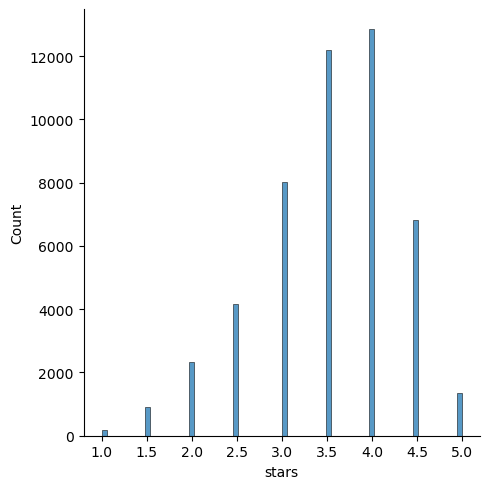

In [28]:
sns.displot(data = df_temp, x = "stars", kind = "hist")

Average stars on yelp received by restaurants grouped by state. 

In [46]:
df_temp = con.sql("""
    SELECT state, avg(stars) as avg_stars FROM restos 
    GROUP BY state
    ORDER BY avg_stars DESC
""").df()
df_temp

,state,avg_stars
0,ABE,4.500000
1,NH,4.000000
2,OR,3.752074
3,TX,3.656262
4,CO,3.587216
5,FL,3.521030
6,MN,3.500000
7,MA,3.480819
8,BC,3.454463
9,WA,3.450202


In [ ]:
Let us look at how many restaurants provide WiFi. 

In [50]:
con.sql("""
    SELECT DISTINCT "attributes.WiFi" FROM restos
""").df()

,attributes.WiFi
0,None
1,u'no'
2,u'paid'
3,'no'
4,'paid'
5,None
6,u'free'
7,'free'


In [58]:
df_temp = con.sql("""
    SELECT "attributes.WiFi" AS wifi, count("attributes.WiFi") AS count FROM restos
    GROUP BY wifi
""").df()
df_temp

,wifi,count
0,None,0
1,u'free',14994
2,'no',4394
3,'free',5496
4,u'paid',184
5,u'no',11706
6,'paid',81
7,None,29


Of course we will need to correct the data because, as you can see, the values of the variable are not clean. There seems to be repetitions of the same thing mentioned in two different ways. 

In [94]:
df_new = pd.DataFrame({
    "wifi": [
        "None",
        "Free",
        "No",
        "Paid"
    ],
    "count": [
        (df_temp["count"][0] + df_temp["count"][7]),
        (df_temp["count"][1] + df_temp["count"][3]),
        (df_temp["count"][2] + df_temp["count"][5]),
        (df_temp["count"][4] + df_temp["count"][6])
    ]
})
df_new

,wifi,count
0,None,29
1,Free,20490
2,No,16100
3,Paid,265


Let us find aggregates of useful votes recevied by reviews grouped by star ratings. 

In [21]:
df_temp = con.sql("""
    SELECT stars, sum(useful) as sum_useful, avg(useful) as avg_useful, max(useful) AS max_useful FROM resto_reviews
    GROUP BY stars
    ORDER BY stars ASC
""").df()
df_temp

,stars,sum_useful,avg_useful,max_useful
0,1,239163.0,1.256445,146
1,2,184718.0,1.192214,260
2,3,216230.0,1.000694,177
3,4,454666.0,1.036895,411
4,5,556257.0,0.825011,223


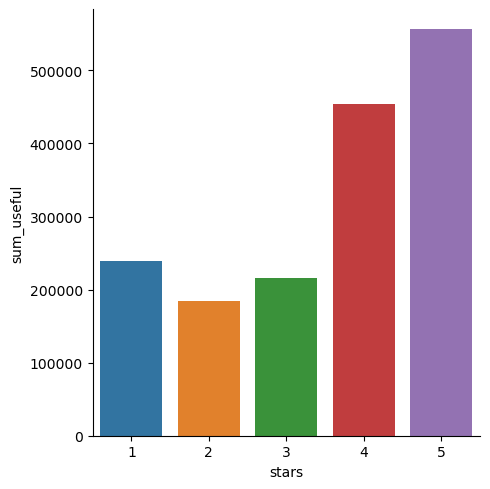

In [108]:
sns.catplot(data = df_temp, x = "stars", y = "sum_useful", kind = "bar")

# Data Preparation

In [47]:
df_resto = con.sql("""
    SELECT * FROM restos 
    LIMIT 50;
""").df()
df_resto

,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,...,attributes.Smoking,attributes.DriveThru,attributes.BYOBCorkage,attributes.Corkage,attributes.RestaurantsCounterService,attributes.DietaryRestrictions,attributes.AgesAllowed,attributes.Open24Hours,attributes.AcceptsInsurance,attributes.HairSpecializesIn
0,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None
1,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None
2,Bob Likes Thai Food,3755 Main St,Vancouver,BC,V5V,49.251342,-123.101333,3.5,169,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None
3,Boxwood Biscuit,740 S High St,Columbus,OH,43206,39.947007,-82.997471,4.5,11,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None
4,Mr G's Pizza & Subs,474 Lowell St,Peabody,MA,01960,42.541155,-70.973438,4.0,39,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None
5,Sister Honey's,247 E Michigan St,Orlando,FL,32806,28.513265,-81.374707,4.5,135,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None
6,Everything POP Shopping & Dining,1050 Century Dr,Orlando,FL,32830,28.350498,-81.542819,3.0,7,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None
7,RaceTrac,350 W Sand Lake Rd,Pine Castle,FL,32809,28.450302,-81.380587,3.5,5,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None
8,Cascade Restaurant,"Hyatt Regency Grand Cypress, 1 Grand Cypress Blvd",Orlando,FL,32836,28.381945,-81.510327,3.5,18,0,...,None,None,None,None,NaN,None,None,NaN,NaN,None
9,Longwood Galleria,340-350 Longwood Ave,Boston,MA,02215,42.338544,-71.106842,2.5,24,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None


In [49]:
df_resto.drop_duplicates()

,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,...,attributes.Smoking,attributes.DriveThru,attributes.BYOBCorkage,attributes.Corkage,attributes.RestaurantsCounterService,attributes.DietaryRestrictions,attributes.AgesAllowed,attributes.Open24Hours,attributes.AcceptsInsurance,attributes.HairSpecializesIn
0,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None
1,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None
2,Bob Likes Thai Food,3755 Main St,Vancouver,BC,V5V,49.251342,-123.101333,3.5,169,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None
3,Boxwood Biscuit,740 S High St,Columbus,OH,43206,39.947007,-82.997471,4.5,11,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None
4,Mr G's Pizza & Subs,474 Lowell St,Peabody,MA,01960,42.541155,-70.973438,4.0,39,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None
5,Sister Honey's,247 E Michigan St,Orlando,FL,32806,28.513265,-81.374707,4.5,135,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None
6,Everything POP Shopping & Dining,1050 Century Dr,Orlando,FL,32830,28.350498,-81.542819,3.0,7,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None
7,RaceTrac,350 W Sand Lake Rd,Pine Castle,FL,32809,28.450302,-81.380587,3.5,5,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None
8,Cascade Restaurant,"Hyatt Regency Grand Cypress, 1 Grand Cypress Blvd",Orlando,FL,32836,28.381945,-81.510327,3.5,18,0,...,None,None,None,None,NaN,None,None,NaN,NaN,None
9,Longwood Galleria,340-350 Longwood Ave,Boston,MA,02215,42.338544,-71.106842,2.5,24,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None


In [51]:
df_resto.describe()

,latitude,longitude,stars,review_count,is_open,int_business_id
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,37.508985,-93.579034,3.570000,91.000000,0.640000,68.740000
std,7.625686,19.662369,0.909193,156.602187,0.484873,41.658872
min,28.350498,-123.140261,1.000000,5.000000,0.000000,1.000000
25%,29.182294,-118.222329,3.500000,15.250000,0.000000,36.250000
50%,40.025611,-83.676167,3.500000,29.500000,1.000000,63.500000
75%,44.770188,-81.339772,4.000000,104.250000,1.000000,105.750000
max,49.286360,-70.916752,5.000000,856.000000,1.000000,137.000000


In [49]:
features = df_resto[[ 'review_count']] 
target = df_resto['stars']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

importance = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': importance})
print(feature_importance_df.sort_values(by='Importance', ascending=False))

Mean Squared Error: 0.9690963900513131
R^2 Score: -0.006853392261104485
        Feature  Importance
0  review_count         1.0


In [19]:
correlation_review_rating = spst.spearmanr(df_resto['review_count'], df_resto['stars'])
print(f"correlation between review count and rating: r={correlation_review_rating.correlation}, p={correlation_review_rating.pvalue}")


correlation between review count and rating: r=0.21767275128966765, p=0.12888288086635213


In [27]:
con.sql("""
    SELECT * FROM resto_reviews
    LIMIT 20;
""")

┌───────┬────────┬───────┬───────┬───┬─────────────────────┬─────────────────┬─────────────┬────────────────────┐
│ stars │ useful │ funny │ cool  │ … │        date         │ int_business_id │ int_user_id │ int_rest_review_id │
│ int64 │ int64  │ int64 │ int64 │   │      timestamp      │      int64      │    int64    │       int64        │
├───────┼────────┼───────┼───────┼───┼─────────────────────┼─────────────────┼─────────────┼────────────────────┤
│     2 │      1 │     1 │     1 │ … │ 2010-01-08 02:29:15 │            4954 │     6319642 │                  2 │
│     2 │      0 │     0 │     0 │ … │ 2006-04-16 02:58:44 │           14180 │      292901 │                  5 │
│     5 │      0 │     0 │     0 │ … │ 2014-05-07 18:10:21 │           11779 │     6336225 │                  7 │
│     5 │      5 │     3 │     3 │ … │ 2014-02-05 21:09:05 │            3216 │      552519 │                 12 │
│     4 │      0 │     0 │     0 │ … │ 2017-05-26 03:05:46 │            8748 │      5440

## Exploratory Data Analysis

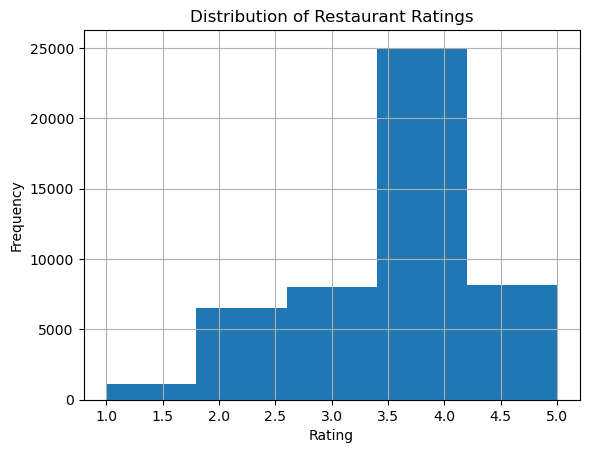

In [37]:
con.sql('''
    SELECT stars 
    FROM restos;
''').df().hist(bins=5)
plt.title('Distribution of Restaurant Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


#### Location Analysis

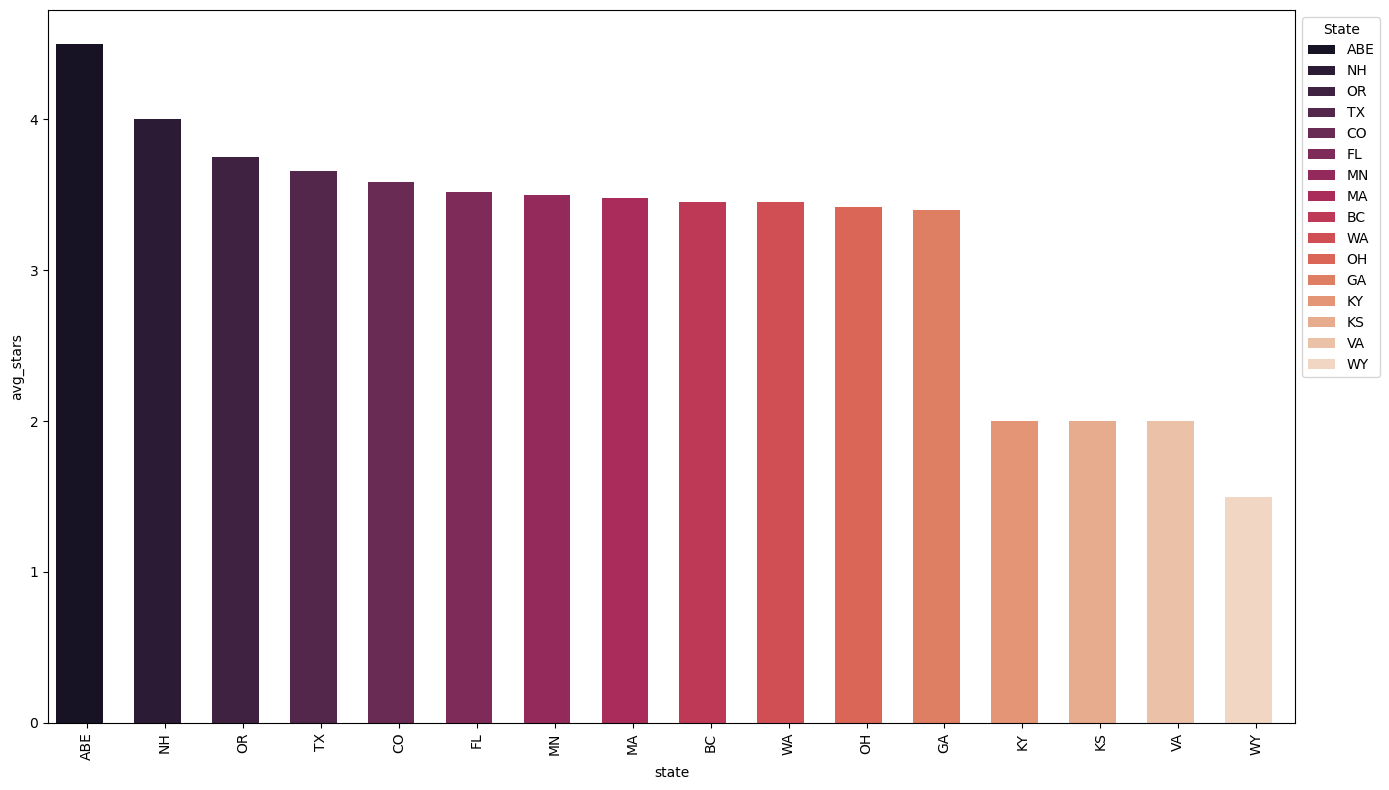

In [47]:
avg_stars_state = con.sql("""
    SELECT state, avg(stars) as avg_stars
    FROM restos
    GROUP BY state
    ORDER BY avg_stars DESC
""").df()

plt.figure(figsize=(14, 8)) 
ax = sns.barplot(data=df_avg_stars_state, x='state', y='avg_stars', hue='state', palette='rocket', dodge=False)

for patch in ax.patches:
    patch.set_width(0.6) 
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='State')
plt.tight_layout()
plt.show()

#### Restaurant Type

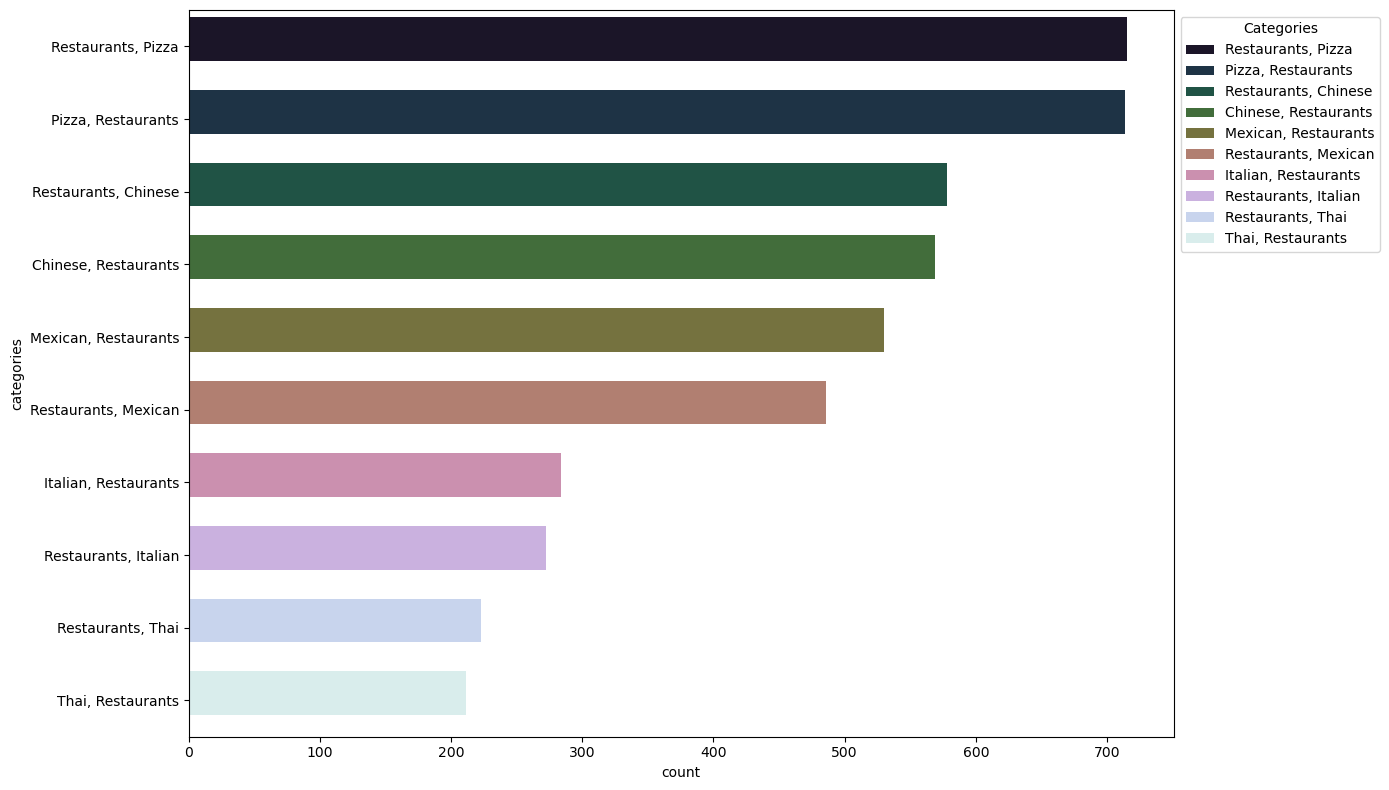

In [51]:
df_categories = con.sql("""
    SELECT categories, count(*) as count
    FROM restos
    GROUP BY categories
    ORDER BY count DESC
    LIMIT 10
""").df()

plt.figure(figsize=(14, 8)) 
ax = sns.barplot(data=df_categories, x='count', y='categories', hue='categories', palette='cubehelix', dodge=False)

for patch in ax.patches:
    patch.set_height(0.6)  

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Categories')
plt.tight_layout()
plt.show()

#### Inner join restos and resto_reviews tables

In [228]:
df_merged = con.sql("""
    SELECT r.int_business_id, r.name, r.stars as resto_avg_stars, 
           rr.stars as review_stars, r."attributes.WiFi", r."attributes.RestaurantsTakeOut"
    FROM restos r
    JOIN resto_reviews rr ON r.int_business_id = rr.int_business_id
""").df()

# Analyze average ratings based on WiFi availability
df_wifi = df_merged.groupby('attributes.WiFi').agg({
    'review_stars': 'mean'
}).reset_index()

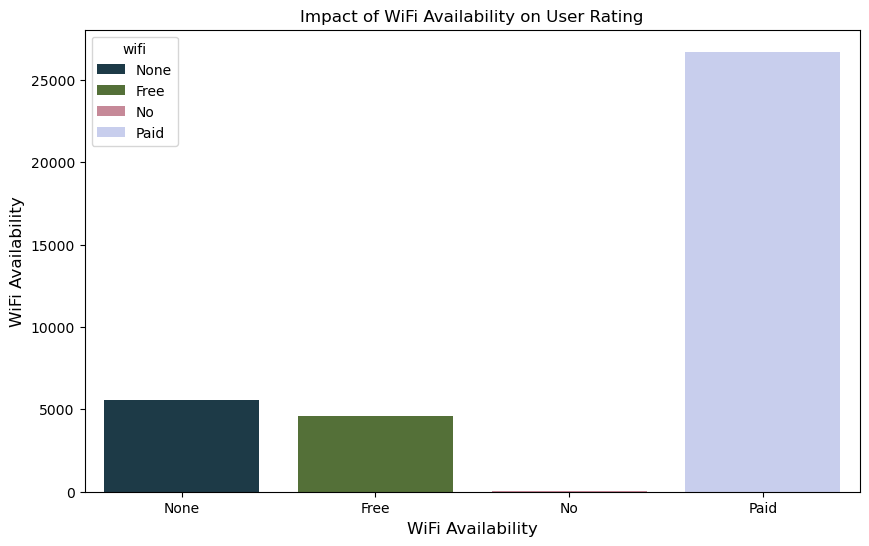

In [40]:
df_temp = con.sql("""
    SELECT "attributes.WiFi" AS wifi, count("attributes.WiFi") AS count FROM restos
    GROUP BY wifi
""").df()
df_temp
df_new = pd.DataFrame({
    "wifi": [
        "None",
        "Free",
        "No",
        "Paid"
    ],
    "count": [
        (df_temp["count"][0] + df_temp["count"][7]),
        (df_temp["count"][1] + df_temp["count"][3]),
        (df_temp["count"][2] + df_temp["count"][5]),
        (df_temp["count"][4] + df_temp["count"][6])
    ]
})
df_new
plt.figure(figsize = (10,6))
sns.barplot(data = df_new, x = "wifi", y = "count", hue = "wifi", dodge = False, palette = 'cubehelix', linewidth=0)
plt.xlabel('WiFi Availability', fontsize=12)
plt.ylabel('WiFi Availability', fontsize=12)
plt.title('Impact of WiFi Availability on User Rating', fontsize=12)
plt.show()

In [61]:
df_amenities = con.sql("""
    SELECT 
        "attributes.OutdoorSeating", "attributes.HappyHour",
        "attributes.Alcohol", "attributes.BusinessAcceptsCreditCards",
        avg(stars) as avg_stars
    FROM restos
    GROUP BY 
        "attributes.OutdoorSeating", "attributes.HappyHour",
        "attributes.Alcohol", "attributes.BusinessAcceptsCreditCards"
    ORDER BY avg_stars DESC
""").df()
df_amenities.head(10)

,attributes.OutdoorSeating,attributes.HappyHour,attributes.Alcohol,attributes.BusinessAcceptsCreditCards,avg_stars
0,True,False,None,False,5.0
1,True,False,u'none',False,4.7
2,None,True,'full_bar',None,4.5
3,None,True,'none',True,4.5
4,True,False,u'beer_and_wine',False,4.5
5,None,False,u'beer_and_wine',False,4.5
6,None,True,u'none',True,4.5
7,None,None,u'none',None,4.5
8,True,False,'beer_and_wine',False,4.5
9,True,True,u'none',False,4.5


<Axes: >

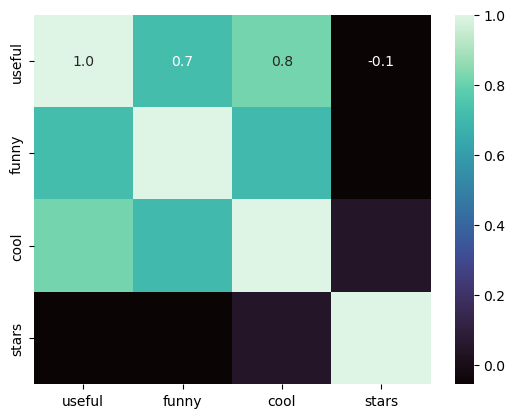

In [65]:
df_review_chars = con.sql("""
    SELECT useful, funny, cool, stars
    FROM resto_reviews
""").df()

sns.heatmap(df_review_chars.corr(), cmap = 'mako', annot = True, fmt = '.1f')

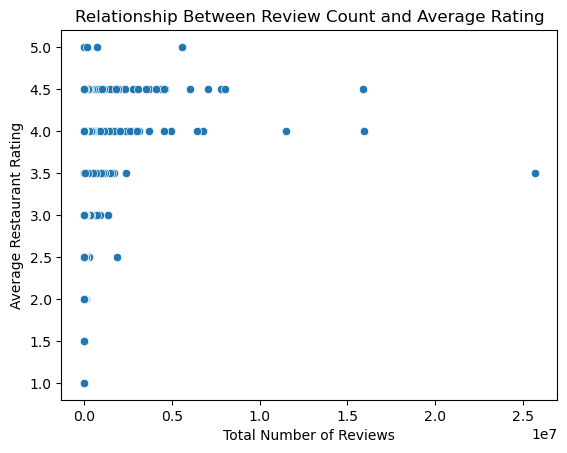

In [67]:
df_merged = con.sql("""
    SELECT r.int_business_id, r.name, r.stars as resto_avg_stars, 
           r.review_count, rr.stars as review_stars
    FROM restos r
    JOIN resto_reviews rr ON r.int_business_id = rr.int_business_id
""").df()

df_grouped = df_merged.groupby('int_business_id').agg({
    'resto_avg_stars': 'mean',
    'review_count': 'sum'
}).reset_index()

sns.scatterplot(data=df_grouped, x='review_count', y='resto_avg_stars')
plt.xlabel('Total Number of Reviews')
plt.ylabel('Average Restaurant Rating')
plt.title('Relationship Between Review Count and Average Rating')
plt.show()

C:\Users\saswa\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


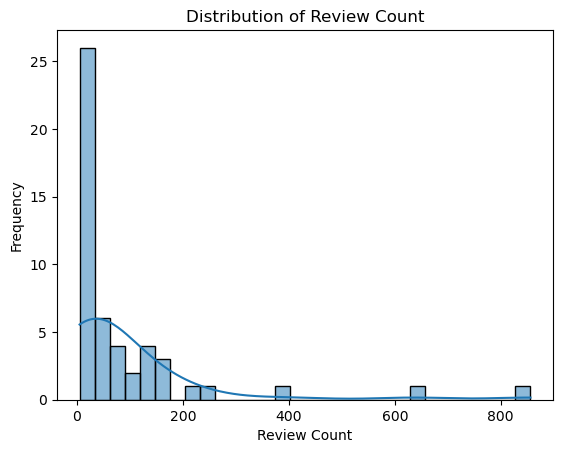

In [53]:
sns.histplot(df_resto['review_count'], bins=30, kde=True)
plt.title('Distribution of Review Count')
plt.xlabel('Review Count')
plt.ylabel('Frequency')
plt.show()

In [69]:
df_ratings_state = con.sql("""
    SELECT state, stars 
    FROM restos
""").df()

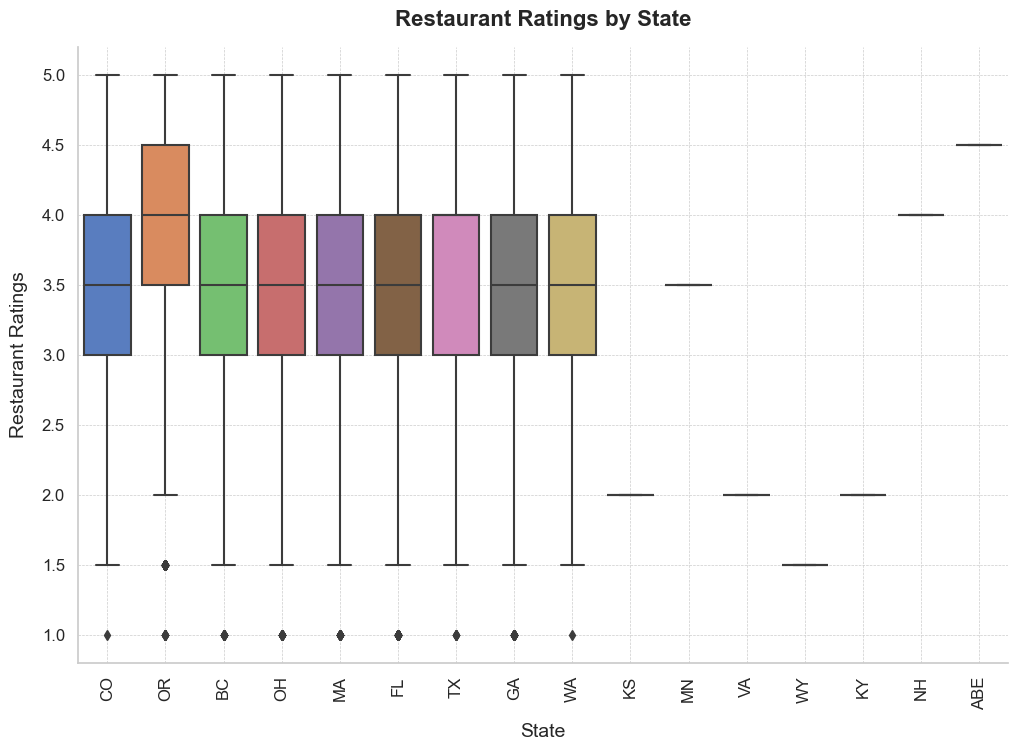

In [75]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))
sns.boxplot(data=df_ratings_state, x='state', y='stars', palette='muted')
plt.xlabel('State', fontsize=14, labelpad=10)
plt.ylabel('Restaurant Ratings', fontsize=14, labelpad=10)
plt.title('Restaurant Ratings by State', fontsize=16, weight='bold', pad=15)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
sns.despine()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Hypothesis Testing

In [79]:
def check_normality(data):
    test_stat_normality, p_value_normality=spst.shapiro(data)
    print("p value:%.4f" % p_value_normality)
    if p_value_normality <0.05:
        print("Reject null hypothesis >> The data is not normally distributed")
    else:
        print("Fail to reject null hypothesis >> The data is normally distributed")

In [82]:
def convert_none_to_zero(data):
    return 0 if pd.isna(data) else 1

## Hypothesis Test 1 - Chi Square Test

### Step 1 : Form Hypothesis

In this case, we are checking if the reviews are dependent on categories of the restaurants.

Ho ( Null Hypothesis ) : Review Count is independent of Category Count 

Ha ( Alternate Hypothesis ) : Review Count is not independent of Category Count

### Step 2 : Collect Data

In [97]:
df_hypothesis1 = con.sql("""
select review_count, categories from restos;
"""
).df()
df_hypothesis1

,review_count,categories
0,86,"Gastropubs, Food, Beer Gardens, Restaurants, B..."
1,126,"Salad, Soup, Sandwiches, Delis, Restaurants, C..."
2,169,"Restaurants, Thai"
3,11,"Breakfast & Brunch, Restaurants"
4,39,"Food, Pizza, Restaurants"
...,...,...
48795,48,"American (Traditional), Desserts, American (Ne..."
48796,310,"Mexican, Bars, Nightlife, Tex-Mex, Restaurants"
48797,185,"Restaurants, Mexican, Latin American"
48798,10,"Cuban, Sandwiches, Restaurants, Cafes"


### Converting the categories to numerical values

In [102]:
templ = []
for x in df_hypothesis1['categories']:
    a = len(x.split(','))
    templ.append(a)
df_hypothesis1['Category Count'] = templ
df_hypothesis1

,review_count,categories,Category Count
0,86,"Gastropubs, Food, Beer Gardens, Restaurants, B...",9
1,126,"Salad, Soup, Sandwiches, Delis, Restaurants, C...",7
2,169,"Restaurants, Thai",2
3,11,"Breakfast & Brunch, Restaurants",2
4,39,"Food, Pizza, Restaurants",3
...,...,...,...
48795,48,"American (Traditional), Desserts, American (Ne...",8
48796,310,"Mexican, Bars, Nightlife, Tex-Mex, Restaurants",5
48797,185,"Restaurants, Mexican, Latin American",3
48798,10,"Cuban, Sandwiches, Restaurants, Cafes",4


In [105]:
contingency_table = pd.crosstab(df_hypothesis1['review_count'], df_hypothesis1['Category Count'])
contingency_table

Category Count,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,23,26,27,28,37
review_count,,,,,,,,,,,,,,,,,,,,,
5,31,489,324,276,224,120,86,27,18,12,...,1,0,0,0,0,0,0,0,0,1
6,21,390,293,267,227,118,63,31,13,7,...,0,0,0,0,0,0,0,0,0,0
7,18,375,284,241,179,97,69,42,19,7,...,0,0,0,0,0,0,0,0,0,0
8,17,308,247,221,165,107,47,38,12,8,...,0,0,0,0,0,0,0,0,0,0
9,13,279,215,212,163,97,45,34,13,3,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5115,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6221,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7219,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Step 3 : Compute Chi Square Test Statistic

In [133]:
stat, p, dof, expected = chi2_contingency(df_hypothesis1[['review_count', 'Category Count']])

### Step 4: Analyse the Chi Square-Stat and compare it with alpha

In [143]:
print("\nChi-square Test Results:")
print("Chi-square value:", stat)
print("P-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies table:")
expected_frequencies = pd.DataFrame(expected)
expected_frequencies


Chi-square Test Results:
Chi-square value: 566898.516679833
P-value: 0.0
Degrees of freedom: 48799
Expected frequencies table:


,0,1
0,91.011223,3.988777
1,127.415712,5.584288
2,163.820202,7.179798
3,12.454167,0.545833
4,40.236541,1.763459
...,...,...
48795,53.648721,2.351279
48796,301.774056,13.225944
48797,180.106421,7.893579
48798,13.412180,0.587820


Since, the p-value is 0 which is lesser than alpha ( 0.05 ), we have enough statistical evidence to reject Null Hypothesis. This means that reviews is not independent of categories.

## Hypothesis Test 2  - Multiple Linear Regression

### Step 1 : Form Hypothesis

Objective : To understand how well Useful, Funny, and Cool predict the Stars rating. This helps assess the collective impact of these variables on Stars.

Independent variables : Useful, funny and cool
Depenedent variable: stars

H0 ( Null Hypothesis ) : The coefficients of Useful, Funny, and Cool are equal to zero

Ha ( Alternate Hypothesis ) : At least one of the coefficients of useful, funny and cool is not qual to zero

### Step 2 : Collect Data

In [159]:
df_hypothesis2 = con.sql("""
select * from resto_reviews
LIMIT 100000;
"""
).df()
df_hypothesis2

,stars,useful,funny,cool,text,date,int_business_id,int_user_id,int_rest_review_id
0,2,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15,4954,6319642,2
1,2,0,0,0,"The setting is perfectly adequate, and the foo...",2006-04-16 02:58:44,14180,292901,5
2,5,0,0,0,I work in the Pru and this is the most afforda...,2014-05-07 18:10:21,11779,6336225,7
3,5,5,3,3,I loved everything about this place. I've only...,2014-02-05 21:09:05,3216,552519,12
4,4,0,0,0,I think their rice dishes are way better than ...,2017-05-26 03:05:46,8748,544027,16
...,...,...,...,...,...,...,...,...,...
99995,5,0,0,0,Just wait in line! Don't get discouraged! Ther...,2016-03-27 20:46:08,1851,402967,333977
99996,5,0,0,0,"Excellent service, food and overall atmosphere...",2014-12-13 18:45:46,14551,9686596,333980
99997,5,0,0,0,Whenever restaurants have house-made veggie bu...,2017-09-30 13:43:07,1646,9876374,333981
99998,2,0,0,0,Of course the view is amazing...and SO much be...,2016-11-07 01:49:43,15925,9825763,333985


In [162]:
x = df_hypothesis2[['useful', 'funny', 'cool']]
y = df_hypothesis2['stars']

### Step 3: Compute Test Statistic 

In [167]:
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  stars   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     1858.
Date:                Sat, 31 Aug 2024   Prob (F-statistic):               0.00
Time:                        17:24:06   Log-Likelihood:            -1.6729e+05
No. Observations:              100000   AIC:                         3.346e+05
Df Residuals:                   99996   BIC:                         3.346e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8170      0.004    849.751      0.000       3.808       3.826
useful        -0.1779      0.003    -51.716      0.000      -0.185      -0.171
funny         -0.1816      0.005    -37.561      0.000      -0.191      -0.172
cool           0.3829      0.006     68.444      0.000       0.372       0.394
==============================================================================
Omnibus:                     8624.380   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10205.729
Skew:                          -0.758   Prob(JB):                         0.00
Kurtosis:                       2.615   Cond. No.                         3.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Step 4: Analyse the F-Stat and compare it with alpha

Alpha = 0.05

Since, p-value = 0, it means we have enough statistical evidence to reject Null Hypothesis. This implies that there is atleast one coefficient which is not equal to 0 which concludes that there is at least one independent variable significant enough that impact stars ( dependedent variable ). If we keep everything else constant, then if that variable is increased by 1 unit, there is an increase of that particular coefficient's units to stars variable.

### Interpretation of R-Square

R-square describes how well the variability in the data is explained by the regression model. So, 5.3% of the variability is explained by the regression model

### 95 % Confidence Interval 

In [181]:
confidence_intervals = model.conf_int(alpha=0.05)
confidence_intervals

,0,1
const,3.808213,3.825821
useful,-0.184689,-0.171201
funny,-0.191097,-0.172143
cool,0.371892,0.393819


## Hypothesis Test 3 - Simple Linear Regression

Independent Variable : Number of friends

Dependent Variable : Number of reviews

H0 ( Null Hypothesis ) : The coefficient for number of friends makes a significant impact on number of reviews is 0.

Ha ( Alternate Hypothesis ) : The coefficient for number of friends makes a signicant impact on number of reviews is not equal to 0.

### Step 2 : Collect Data

In [190]:
joined_table = con.sql("""
SELECT u.review_count as Num_Reviews, f.num_friends as Num_Friends
FROM users u
LEFT JOIN user_friends f
ON u.int_user_id = f.int_user_id;
""").df()
joined_table

,Num_Reviews,Num_Friends
0,187,2
1,13,3
2,90,1
3,2,1
4,3,1
...,...,...
2189452,1,0
2189453,3,0
2189454,2,0
2189455,1,0


### Step 3 : Compute Linear Regression ( Test Statistic )

In [195]:
x1 = joined_table['Num_Friends']
y1 = joined_table['Num_Reviews']

x1 = sm.add_constant(x1)
model1 = sm.OLS(y1, x1).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Num_Reviews   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                 3.597e+05
Date:                Sat, 31 Aug 2024   Prob (F-statistic):               0.00
Time:                        17:26:51   Log-Likelihood:            -1.2423e+07
No. Observations:             2189457   AIC:                         2.485e+07
Df Residuals:                 2189455   BIC:                         2.485e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          11.2056      0.051    220.923      0.000      11.106      11.305
Num_Friends     0.1996      0.000    599.714      0.000       0.199       0.200
==============================================================================
Omnibus:                  5603470.749   Durbin-Watson:                   1.788
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    1039125953855.817
Skew:                          28.010   Prob(JB):                         0.00
Kurtosis:                    3377.517   Cond. No.                         162.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Step 4: Analyse the F-Stat and compare it with alpha

Alpha = 0.05

Since, p-value << alpha, it means we have enough statistical evidence to reject Null Hypothesis. This implies that coefficient of number of friends makes a signicant impact on the number of reviews.

### Interepretation of R Square

In this case, R square is coming approx 15%. This means that 15% of the variability in the data is explained by the Regression model. It describes how well the data is fitted into the model.

In [202]:
check2 = con.sql("""
select * from restos limit 10;
"""    
).df()
check2

,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,...,attributes.Smoking,attributes.DriveThru,attributes.BYOBCorkage,attributes.Corkage,attributes.RestaurantsCounterService,attributes.DietaryRestrictions,attributes.AgesAllowed,attributes.Open24Hours,attributes.AcceptsInsurance,attributes.HairSpecializesIn
0,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None
1,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None
2,Bob Likes Thai Food,3755 Main St,Vancouver,BC,V5V,49.251342,-123.101333,3.5,169,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None
3,Boxwood Biscuit,740 S High St,Columbus,OH,43206,39.947007,-82.997471,4.5,11,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None
4,Mr G's Pizza & Subs,474 Lowell St,Peabody,MA,01960,42.541155,-70.973438,4.0,39,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None
5,Sister Honey's,247 E Michigan St,Orlando,FL,32806,28.513265,-81.374707,4.5,135,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None
6,Everything POP Shopping & Dining,1050 Century Dr,Orlando,FL,32830,28.350498,-81.542819,3.0,7,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None
7,RaceTrac,350 W Sand Lake Rd,Pine Castle,FL,32809,28.450302,-81.380587,3.5,5,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None
8,Cascade Restaurant,"Hyatt Regency Grand Cypress, 1 Grand Cypress Blvd",Orlando,FL,32836,28.381945,-81.510327,3.5,18,0,...,None,None,None,None,NaN,None,None,NaN,NaN,None
9,Longwood Galleria,340-350 Longwood Ave,Boston,MA,02215,42.338544,-71.106842,2.5,24,1,...,None,None,None,None,NaN,None,None,NaN,NaN,None


In [205]:
city = con.sql("""
select city,
"attributes.RestaurantsTableService", 
"attributes.WiFi", 
"attributes.OutdoorSeating",
"attributes.RestaurantsGoodForGroups",
"attributes.HappyHour",
"attributes.Ambience",
"attributes.HasTv",
"attributes.Alcohol",
from restos limit 10;
"""    
).df()
city

,city,attributes.RestaurantsTableService,attributes.WiFi,attributes.OutdoorSeating,attributes.RestaurantsGoodForGroups,attributes.HappyHour,attributes.Ambience,attributes.HasTV,attributes.Alcohol
0,Boulder,True,u'free',True,True,True,"{'touristy': False, 'hipster': False, 'romanti...",True,'beer_and_wine'
1,Portland,None,u'free',False,False,None,"{'romantic': False, 'intimate': False, 'touris...",False,u'beer_and_wine'
2,Vancouver,None,u'no',False,True,None,"{'romantic': False, 'intimate': False, 'classy...",False,u'none'
3,Columbus,None,None,None,None,None,None,None,None
4,Peabody,False,u'free',True,True,None,"{'romantic': False, 'intimate': False, 'classy...",True,u'none'
5,Orlando,None,None,None,None,None,None,None,None
6,Orlando,None,u'free',None,True,None,None,False,None
7,Pine Castle,None,None,False,True,None,"{'touristy': False, 'hipster': False, 'romanti...",True,'none'
8,Orlando,None,'free',True,True,None,"{'romantic': False, 'intimate': False, 'classy...",True,'full_bar'
9,Boston,None,'free',False,True,None,"{'romantic': False, 'intimate': False, 'classy...",False,'full_bar'


### Hypothesis Test 4
### Ho: Population mean rating of restaurants serving alcohol is less than or equal to Population mean of restaurants not serving alcohol.
### Ha: Population mean rating of restaurants serving alcohol is greater than the Population mean of restaurants not serving alcohol .

In [216]:
ratings_serving_alcohol=con.sql(""" SELECT stars as rating from restos WHERE "attributes.Alcohol" not like '%none%' AND "attributes.Alcohol" not like '%None%' """).df()
ratings_not_serving_alcohol=con.sql(""" SELECT stars as rating from restos WHERE "attributes.Alcohol" like '%none%' OR "attributes.Alcohol" like '%None%' """).df()

ratings_serving_alcohol = ratings_serving_alcohol['rating'].dropna().to_numpy()
ratings_not_serving_alcohol = ratings_not_serving_alcohol['rating'].dropna().to_numpy()

if len(ratings_serving_alcohol) == 0 or len(ratings_not_serving_alcohol) == 0:
    print("One of the arrays is empty. Cannot perform t-test.")
elif np.var(ratings_serving_alcohol) == 0 or np.var(ratings_not_serving_alcohol) == 0:
    print("One of the arrays has no variance. Cannot perform t-test.")
else:
    # two-tailed t-test
    t_statistic, p_value_two_tailed = spst.ttest_ind(ratings_serving_alcohol, ratings_not_serving_alcohol)

    # Convert to one-tailed p-value
    if t_statistic > 0:
        p_value_one_tailed = p_value_two_tailed / 2
    else:
        p_value_one_tailed = 1 - (p_value_two_tailed / 2)
        
    print(f"T-statistic: {t_statistic}")
    print(f"One-tailed P-value: {p_value_one_tailed}")


    alpha = 0.05
    if p_value_one_tailed < alpha:
        print("Reject the null hypothesis: The mean rating of restaurants serving alcohol is significantly greater.")
    else:
        print("Fail to reject the null hypothesis: There is no significant difference in mean ratings.")

T-statistic: 12.800173368523778
One-tailed P-value: 9.712319877930074e-38
Reject the null hypothesis: The mean rating of restaurants serving alcohol is significantly greater.


## Confidence interval for proportion of restaurants which has outdoor dining area

In [33]:
df_temp_3 = con.sql("""
    SELECT count(*), "attributes.OutdoorSeating" from restos
    group by "attributes.OutdoorSeating" ;
""").df()
df_temp_3

,count_star(),attributes.OutdoorSeating
0,20619,False
1,2159,None
2,19858,True
3,6164,None


In [35]:
proportion_of_outdoor_eating=19858/(20619+19858)
n=20619+19858;
se_proportion_outdoor = np.sqrt(proportion_of_outdoor_eating * (1 - proportion_of_outdoor_eating) / n)
se_proportion_outdoor

0.0024847864912894793

In [37]:
margin_of_error = 1.96 * se_proportion_outdoor
confidence_interval = (proportion_of_outdoor_eating - margin_of_error, proportion_of_outdoor_eating + margin_of_error)
confidence_interval

(0.48572941824978305, 0.49546978129563785)

#### we can say that, the proportion of restaurants having outdoor eating is between the CI 0.48 and 0.49

### Confidence interval for the mean rating of restaurants where alcholol is served

In [232]:
df_CI=con.sql(""" SELECT stars as rating from restos WHERE "attributes.Alcohol" not like '%none%' AND "attributes.Alcohol" not like '%None%' """).df()

mean_rating = df_CI['rating'].mean()
sem_rating = spst.sem(df_CI['rating'], nan_policy='omit')  

confidence_level = 0.95
degrees_freedom = len(df_CI['rating']) - 1
confidence_interval = spst.t.interval(confidence_level, degrees_freedom, loc=mean_rating, scale=sem_rating)

print(f"Mean Rating: {mean_rating}")
print(f"{confidence_level*100}% Confidence Interval for the Mean Rating: {confidence_interval}")


Mean Rating: 3.583017437452616
95.0% Confidence Interval for the Mean Rating: (3.5747438580283766, 3.591291016876855)


In [214]:
df1 = con.sql("""
    SELECT stars, review_count
    
    FROM restos
    ORDER BY stars ASC
""").df()

X = df1['review_count'] 
y = df1['stars']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  stars   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1091.
Date:                Sat, 31 Aug 2024   Prob (F-statistic):          1.22e-236
Time:                        17:34:14   Log-Likelihood:                -56193.
No. Observations:               48800   AIC:                         1.124e+05
Df Residuals:                   48798   BIC:                         1.124e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.4691      0.004    890.918   

### Interpretation of the Linear Regression Analysis

The provided output represents the results of an OLS (Ordinary Least Squares) regression analysis, where the dependent variable is the `rating` given to a restaurant, and the independent variable is `review_length`, which presumably measures the number of words in a review.

#### 1. **Regression Coefficients**
   - **Intercept (3.4691)**: This value indicates that when the `review_count` is zero (i.e., when a review has no words), the expected average rating is approximately 3.4691. This serves as the baseline rating.
   - **review_count (0.0005)**: The coefficient for `review_count` is 0.0005, meaning that for every additional word in a review, the rating increases by approximately 0.0005 points. 

#### 2. **Statistical Significance**
   - **P>|t| for review_length (0.000)**: The p-value for `review_count` is extremely small (0.000), which indicates that the relationship between review count and rating is statistically significant. In other words, there's a very low probability that this relationship is due to random chance.
   - **t-statistic for review_length (33.030)**: The t-value suggests that the effect of review length on rating is strong and positive.

#### 3. **Model Fit**
   - **R-squared (0.022)**: The R-squared value of 0.022 indicates that only 2.2% of the variability in restaurant ratings can be explained by the length of the review. This suggests that while the relationship between review length and rating is statistically significant, it is not practically significant, as review length only explains a small fraction of the variation in ratings.
   - **Adj. R-squared (0.022)**: The adjusted R-squared is nearly identical to the R-squared value, which is typical in models with a single predictor. This confirms that adding more variables to the model might be necessary to better explain the variability in ratings.

#### 4. **Overall Model Significance**
   - **F-statistic (1091) and Prob (F-statistic) (1.22e-236)**: The F-statistic and its associated p-value (0.00) suggest that the model as a whole is statistically significant. This means that the regression model provides a better fit to the data than a model with no predictors.

#### 5. **Diagnostic Tests**
   - **Omnibus, Prob(Omnibus), Skew, Kurtosis**: These statistics assess the normality of residuals. The large values and low p-values here suggest that the residuals deviate from normality, which might imply potential issues in the model fit or the need for data transformation.
   - **Durbin-Watson (0.043)**: This value indicates no significant autocorrelation in the residuals.
   - **Jarque-Bera (1957.536) and Prob(JB) (0.00)**: These values also test for normality. The very low p-value indicates that the residuals are not normally distributed.

### Summary

- **Relationship**: There is a statistically significant but practically weak inverse relationship between the length of a review and the rating given. Longer reviews are associated with slightly lower ratings.
  
- **Model Fit**: The model explains only 2.4% of the variability in ratings, suggesting that other factors not included in the model may better explain the ratings.
  
- **Model Significance**: Despite the weak practical significance, the overall model is statistically significant.

- **Residual Analysis**: There might be concerns regarding the normality of residuals, which could suggest potential issues with the model or the need for further analysis.

In conclusion, while there is a measurable relationship between review length and rating, its impact is minimal, and additional variables may need to be considered to build a more predictive model.